Completed iteration 25 with error 1.485607294436619.
Completed iteration 50 with error 0.4109923604704733.
Completed iteration 75 with error 0.11943652891578438.
Completed iteration 100 with error 0.03520991052219813.
Completed iteration 125 with error 0.010428612602680687.
Completed iteration 150 with error 0.0030888318789976665.
Completed iteration 175 with error 0.0009148755418664223.
Completed iteration 200 with error 0.0002709753362921674.
Completed iteration 225 with error 8.025969601987981e-05.
Completed iteration 250 with error 2.3771974582587063e-05.
Completed iteration 275 with error 7.040978260874908e-06.
Completed iteration 300 with error 2.085454667621889e-06.
Terminated successfully in 317 interations.


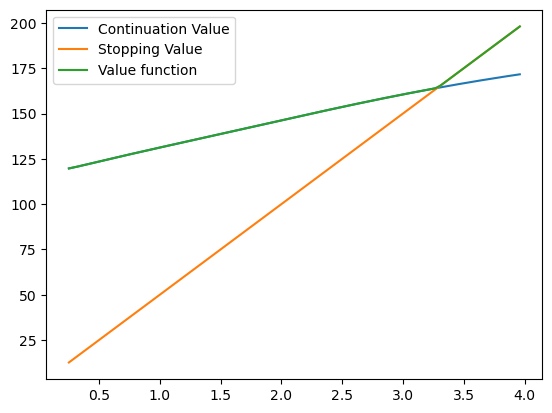

In [98]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#                DYNAMIC PROGRAMMING BY JOHN STARCHURSKI AND THOMAS SARGENT                  #
#                                                                                            #
# This code is used for Chapter 3 Markov Dynamics: Job-Search Model with Markov wages        #
# Written by Longye Tian 24/06/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#



#--------------------------------------------------------------------------------------------#
#                              IMPORT LIBRARIES AND PACKAGES                                 #
#--------------------------------------------------------------------------------------------#

import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

#--------------------------------------------------------------------------------------------#
#                          CREATE NAMEDTUPLE TO STORE MODEL PARAMETERS                       #
#--------------------------------------------------------------------------------------------#

Job_Search_Markov = namedtuple("job_search_markov", 
                               ("n",                           # wage grid size
                                "m",                           # number of std
                                "ρ",                           # wage persistence
                                "ν",                           # wage volatility coefficent
                                "β",                           # discount factor
                                "c"                            # unemployment compensation
                               ))      

def create_job_search_markov_model(n=200, m=3,ρ=0.9, ν=0.2, β=0.98, c=1.0):
    return Job_Search_Markov(n=n,m=m,ρ=ρ, ν=ν, β=β, c=c)



def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p


#--------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                      #
#--------------------------------------------------------------------------------------------#

def Tauchen(job_search_markov):  
    n,m,ρ,ν,β,c = job_search_markov             # Unpack model parameters
    σ_w = np.sqrt(ν**2/(1-ρ**2))                               # W's std
    W = np.linspace(-m*σ_w, m*σ_w, n)                          # State space by Tauchen
    s = (W[n-1]-W[0])/(n-1)                                    # gap between two states
    P = np.zeros((n,n))                                        # Initialize P
    for i in range(n):
        P[i,0] = norm_cdf(W[0]-ρ*W[i]+s/2, std=σ_w)            # j=1
        P[i,n-1] = 1 - norm_cdf(W[n-1]-ρ*W[i]-s/2, std=σ_w)    # j=n
        for j in range(1,n-1):
            P[i,j] = norm_cdf(W[j]-ρ*W[i]+s/2, std=σ_w)-norm_cdf(W[j]-ρ*W[i]-s/2, std=σ_w)
    W = np.exp(W)
    return W,P
    


# job_search_markov = create_job_search_markov_model()
# W,P = Tauchen(job_search_markov)

# Check the row sum
# for i in range(n):
#    if np.sum(P[i])!=1:
#        print(i, np.sum(P[i]))


#--------------------------------------------------------------------------------------------#
#                    BELLMAN OPERATOR IN JOB SEARCH MDOEL WITH MARKOV WAGE                   #
#--------------------------------------------------------------------------------------------#

def T (v, job_search_markov):
    n,m,ρ,ν,β,c = job_search_markov                              # Unpack model parameters
    W,P = Tauchen(job_search_markov)                             # Get W and P
    h = c + β * P@v                                              # Continuation value
    e = W/(1-β)                                                  # Stopping value
    return np.maximum(e,h)


#--------------------------------------------------------------------------------------------#
#                                   v-greedy policy                                          #
#--------------------------------------------------------------------------------------------#

def get_greedy (v, job_search_markov): 
    n,m,ρ,ν,β,c = job_search_markov                              # Unpack model parameters
    W,P = Tauchen(job_search_markov)                             # Get W and P
    h = c + β * P@v                                              # Continuation value
    e = W/(1-β)                                                  # Stopping value
    σ= np.where(e>=h, 1, 0)                                      
    return σ


#--------------------------------------------------------------------------------------------#
#                            SUCCESSIVE APPROXIMATION ALGORITHM                              #
#--------------------------------------------------------------------------------------------#

def successive_approx (T,                                         # A callable operator
                       v_0,                                       # Initial condition
                       job_search_markov,                         # Model parameter
                       tol = 1e-6,                                # Error tolerance
                       max_iter = 10_000,                         # max iterations
                       print_step = 25                            # Print at multiples of print_step
                      ):
    v = v_0                                                       # set the initial condition
    error = tol + 1                                               # Initialize the error
    k = 1                                                         # initialize the iteration
    
    while (error > tol) and (k <= max_iter): 
        v_new = T(v,job_search_markov)                            # update by applying operator T
        error = np.max(np.abs(v_new-v))                           # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = v_new                                                 # update x
        k += 1                                                    # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v                                                     


#--------------------------------------------------------------------------------------------#
#                                 VALUE FUNCTION ITERATION                                   #
#--------------------------------------------------------------------------------------------#

def value_function_iteration (job_search_markov):
    n,m,ρ,ν,β,c = job_search_markov                              # Unpack model parameters
    W,P = Tauchen(job_search_markov)
    v_init = W/(1-β)                                        # initialize Value function
    v_star = successive_approx(T, v_init, job_search_markov)    
    σ_star = get_greedy(v_star, job_search_markov)                # σ* is v*-greedy
    return v_star, σ_star



#--------------------------------------------------------------------------------------------#
#                   PLOT CONTINUATION, STOPPING AND VALUE FUNCTIONS                          #
#--------------------------------------------------------------------------------------------#

def plot_value_stopping_continue (job_search_markov):
    n,m,ρ,ν,β,c = job_search_markov                              # Unpack model parameters
    W,P= Tauchen(job_search_markov)                             # Get W and P
    v_star, σ_star = value_function_iteration(job_search_markov) 
    h = c + β * P@v_star                                            # Continuation value function
    e = W/(1-β)                                                  # Stopping value
    plt.plot(W, h, label='Continuation Value')
    plt.plot(W, e, label='Stopping Value')
    plt.plot(W, v_star, label='Value function')
    plt.legend()
    plt.show()
    
job_search_markov = create_job_search_markov_model()
plot_value_stopping_continue (job_search_markov)

Completed iteration 25 with error 0.6714909990420068.
Completed iteration 50 with error 0.31127183410347214.
Completed iteration 75 with error 0.1549416145639313.
Completed iteration 100 with error 0.07901407659711168.
Completed iteration 125 with error 0.04072040663297116.
Completed iteration 150 with error 0.021049452995697493.
Completed iteration 175 with error 0.010979051705120924.
Completed iteration 200 with error 0.0056745110295537415.
Completed iteration 225 with error 0.002918116438380025.
Completed iteration 250 with error 0.0014966543056971204.
Completed iteration 275 with error 0.0007665490277020126.
Completed iteration 300 with error 0.00039360790459852524.
Completed iteration 325 with error 0.00020797998294597164.
Completed iteration 350 with error 0.00010993143968107688.
Completed iteration 375 with error 5.810139342088405e-05.
Completed iteration 400 with error 3.070663855453404e-05.
Completed iteration 425 with error 1.6228112599492306e-05.
Completed iteration 450 with

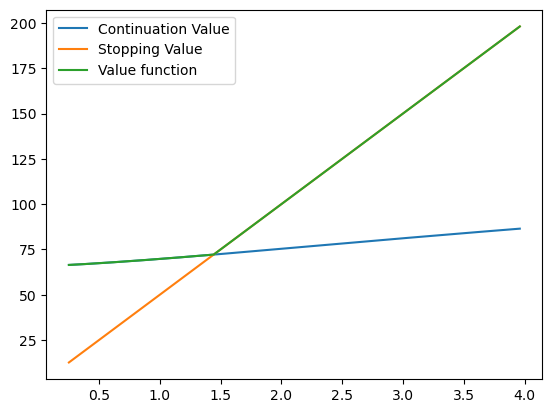

In [103]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#                DYNAMIC PROGRAMMING BY JOHN STARCHURSKI AND THOMAS SARGENT                  #
#                                                                                            #
# This code is used for Chapter 3 Markov Dynamics: Job-Search Model with Markov wages        #
# Written by Longye Tian 24/06/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#



#--------------------------------------------------------------------------------------------#
#                              IMPORT LIBRARIES AND PACKAGES                                 #
#--------------------------------------------------------------------------------------------#

import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

#--------------------------------------------------------------------------------------------#
#                          CREATE NAMEDTUPLE TO STORE MODEL PARAMETERS                       #
#--------------------------------------------------------------------------------------------#

Job_Search_Markov = namedtuple("job_search_markov", 
                               ("n",                           # wage grid size
                                "m",                           # number of std
                                "ρ",                           # wage persistence
                                "ν",                           # wage volatility coefficent
                                "β",                           # discount factor
                                "c",                           # unemployment compensation
                                "θ"                            # Risk sensitivity
                               ))      

def create_job_search_markov_model(n=200, m=3,ρ=0.9, ν=0.2, β=0.98, c=1.0, θ=-0.2):
    return Job_Search_Markov(n=n,m=m,ρ=ρ, ν=ν, β=β, c=c, θ=θ)



def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p


#--------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                      #
#--------------------------------------------------------------------------------------------#

def Tauchen(job_search_markov):  
    n,m,ρ,ν,β,c,θ = job_search_markov             # Unpack model parameters
    σ_w = np.sqrt(ν**2/(1-ρ**2))                               # W's std
    W = np.linspace(-m*σ_w, m*σ_w, n)                          # State space by Tauchen
    s = (W[n-1]-W[0])/(n-1)                                    # gap between two states
    P = np.zeros((n,n))                                        # Initialize P
    for i in range(n):
        P[i,0] = norm_cdf(W[0]-ρ*W[i]+s/2, std=σ_w)            # j=1
        P[i,n-1] = 1 - norm_cdf(W[n-1]-ρ*W[i]-s/2, std=σ_w)    # j=n
        for j in range(1,n-1):
            P[i,j] = norm_cdf(W[j]-ρ*W[i]+s/2, std=σ_w)-norm_cdf(W[j]-ρ*W[i]-s/2, std=σ_w)
    W = np.exp(W)
    return W,P
    


# job_search_markov = create_job_search_markov_model()
# W,P = Tauchen(job_search_markov)

# Check the row sum
# for i in range(n):
#    if np.sum(P[i])!=1:
#        print(i, np.sum(P[i]))


#--------------------------------------------------------------------------------------------#
#                    BELLMAN OPERATOR IN JOB SEARCH MDOEL WITH MARKOV WAGE                   #
#--------------------------------------------------------------------------------------------#

def T (v, job_search_markov):
    n,m,ρ,ν,β,c, θ = job_search_markov                              # Unpack model parameters
    W,P = Tauchen(job_search_markov)                             # Get W and P
    h = c + β/θ * np.log(P@(np.exp(θ * v)))                                              # Continuation value
    e = W/(1-β)                                                  # Stopping value
    return np.maximum(e,h)


#--------------------------------------------------------------------------------------------#
#                                   v-greedy policy                                          #
#--------------------------------------------------------------------------------------------#

def get_greedy (v, job_search_markov): 
    n,m,ρ,ν,β,c, θ = job_search_markov                              # Unpack model parameters
    W,P = Tauchen(job_search_markov)                             # Get W and P
    h = c + β/θ * np.log(P@(np.exp(θ * v)))                                              # Continuation value
    e = W/(1-β)                                                  # Stopping value
    σ= np.where(e>=h, 1, 0)                                      
    return σ


#--------------------------------------------------------------------------------------------#
#                            SUCCESSIVE APPROXIMATION ALGORITHM                              #
#--------------------------------------------------------------------------------------------#

def successive_approx (T,                                         # A callable operator
                       v_0,                                       # Initial condition
                       job_search_markov,                         # Model parameter
                       tol = 1e-6,                                # Error tolerance
                       max_iter = 10_000,                         # max iterations
                       print_step = 25                            # Print at multiples of print_step
                      ):
    v = v_0                                                       # set the initial condition
    error = tol + 1                                               # Initialize the error
    k = 1                                                         # initialize the iteration
    
    while (error > tol) and (k <= max_iter): 
        v_new = T(v,job_search_markov)                            # update by applying operator T
        error = np.max(np.abs(v_new-v))                           # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = v_new                                                 # update x
        k += 1                                                    # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v                                                     


#--------------------------------------------------------------------------------------------#
#                                 VALUE FUNCTION ITERATION                                   #
#--------------------------------------------------------------------------------------------#

def value_function_iteration (job_search_markov):
    n,m,ρ,ν,β,c, θ = job_search_markov                              # Unpack model parameters
    W,P = Tauchen(job_search_markov)
    v_init = W/(1-β)                                        # initialize Value function
    v_star = successive_approx(T, v_init, job_search_markov)    
    σ_star = get_greedy(v_star, job_search_markov)                # σ* is v*-greedy
    return v_star, σ_star



#--------------------------------------------------------------------------------------------#
#                   PLOT CONTINUATION, STOPPING AND VALUE FUNCTIONS                          #
#--------------------------------------------------------------------------------------------#

def plot_value_stopping_continue (job_search_markov):
    n,m,ρ,ν,β,c, θ = job_search_markov                              # Unpack model parameters
    W,P= Tauchen(job_search_markov)                             # Get W and P
    v_star, σ_star = value_function_iteration(job_search_markov) 
    h = c + β/θ * np.log(P@(np.exp(θ * v_star)))                                       # Continuation value function
    e = W/(1-β)                                                  # Stopping value
    plt.plot(W, h, label='Continuation Value')
    plt.plot(W, e, label='Stopping Value')
    plt.plot(W, v_star, label='Value function')
    plt.legend()
    plt.show()
    
job_search_markov = create_job_search_markov_model()
plot_value_stopping_continue (job_search_markov)

In [106]:
np.linspace(-0.1, 0.1, 50)

array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
       -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
       -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
       -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
       -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
        0.00204082,  0.00612245,  0.01020408,  0.01428571,  0.01836735,
        0.02244898,  0.02653061,  0.03061224,  0.03469388,  0.03877551,
        0.04285714,  0.04693878,  0.05102041,  0.05510204,  0.05918367,
        0.06326531,  0.06734694,  0.07142857,  0.0755102 ,  0.07959184,
        0.08367347,  0.0877551 ,  0.09183673,  0.09591837,  0.1       ])

In [113]:
import seaborn as sns
sns.set_style("darkgrid")  # or any other seaborn style

In [115]:
np.linspace(-1, 1, 50)

array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
       -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
       -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
       -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
       -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
        0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
        0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
        0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
        0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
        0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ])